# Classification Predict Student Solution

© Explore Data Science Academy

---
### Honour Code

We, **Team 6**, confirm - by submitting this document - that the solutions in this notebook are a result of our own work and that we abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

### Predict Overview: EDSA - Climate Change Belief Analysis 2022

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, you are challenged to create a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.


  ### Sentiment Description
  
        Class   Sentiments    Description
         2	   News:         tweets that links news articles about climate change
         1       Pro:          the tweet expresses supports for the belief in man-made climate change
         0	   Neutral:      the tweet neither expresses supports nor refutes man-made climate change
        -1       Anti:         the tweet expresses disbelief in man-made climate change

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Importing Packages ⚡ |
| :--------------------------- |
| In this section you are required to import, and briefly discuss, the libraries that will be used throughout your analysis and modelling. |

---

In [1]:
# Please uncomment and install any of the following packages if you are missing any.

# pip install comet_ml
# pip install langdetect
# pip install contractions
# pip install fasttext
# pip install spacy
# pip install imblearn
# !pip install scikit-plot

In [2]:
%matplotlib inline

from comet_ml import Experiment

import string
import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils import resample

from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

import nltk
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


import pickle

In [3]:
# Uncomment and download any of the following packages if you are missing any

# nltk.download('stopwords')
# nltk.download('punkt')
# spacy.cli.download('en_core_web_sm')

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Loading the data ⚡ |
| :--------------------------- |
| In this section you are required to load the data from the `train.csv` file into a DataFrame. |

---

Train.csv: Dataset for training the model

Test.csv : We will generate predictions with this dataset for use in a kaggle competition

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


<a id="three"></a>
## 3. Exploratory Data Analysis
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Explore the data ⚡ |
| :--------------------------- |
| In this section we explore the patterns in the data |

---

We begin by checking if the dataset contians null or missing values

In [5]:
train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [6]:
test.isnull().sum()

message    0
tweetid    0
dtype: int64

We see that both datasets do not contain null/missing values

### Sentiment visual distributions

Let us now take a look at the different sentiments expressesed in the dataset

In [96]:
train.sentiment.unique()

array([ 1,  2,  0, -1])

##### we note the different sentimenets in the dataframe
  
        Class   Sentiments    Description
         2	   News:         tweets that links news articles about climate change
         1       Pro:          the tweet expresses supports for the belief in man-made climate change
         0	   Neutral:      the tweet neither expresses supports nor refutes man-made climate change
        -1       Anti:         the tweet expresses disbelief in man-made climate change

In [97]:
# for the proceeding analysis we will make a copy of the train dataset
train1 = train.copy()

#### Next we explore the no of tweets per Sentiment expressed in our training data

Text(0.5, 1.0, 'Class Distributions')

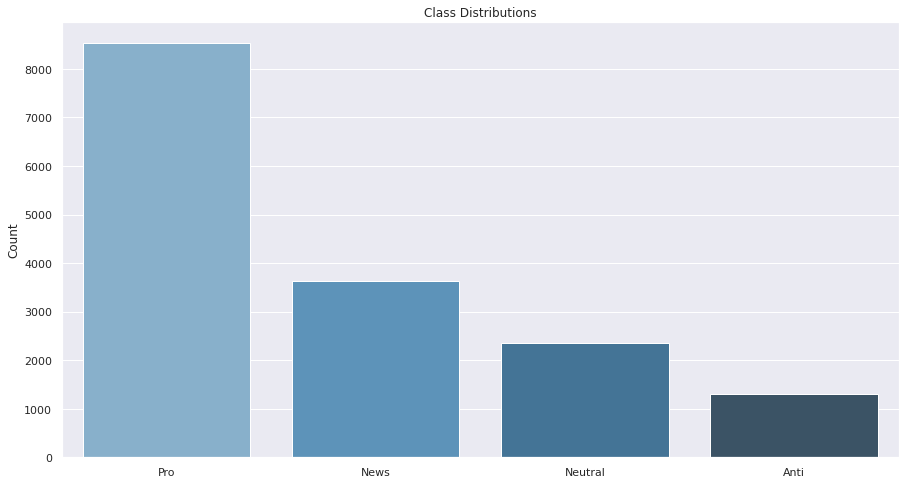

In [98]:
'''
We calculate the number of tweets per Sentiment,

we then plot the class distributions results'''

# Number of tweets per sentiment
class_distribution = pd.DataFrame(list(train1['sentiment'].value_counts()),
                          index=['Pro', 'News', 'Neutral', 'Anti'],
                          columns=['Count'])

sns.set()
sns.barplot(x=class_distribution.index, y=class_distribution.Count, 
           palette="Blues_d")
plt.title('Class Distributions')

**Observations:**

* Looking at the distribution we are able to see that the data is unbalanced, most observations in the dataset are Pro climate change. 

* With umbalaced data such as this, we run the risk of training a model that is specialized in categorizing pro tweets while misclassifying other less represented groups.

* We will attempt to balance the data and then train our models using both the balanced and unbalanced data. This way we can compare the performance of both approaches.

#### Next we explore the occurrence of words in the different sentiments

This makes it possible to explore possible patterns in the words used to expressed the different sentiments in the tweets

In [108]:
# We will drop the tweetid column and remove the stopwords for this analysis
# The presence of stopwords will distort the data shown

def remove_stop_words(word):
    word_list = word.split(" ")
    stop_words = stopwords.words('english')
    clean = []
    return " ".join([word for word in word_list if word not in stop_words ])
    
tweet_df = train1.drop(['tweetid'], axis=1)
tweet_df["message"] = tweet_df["message"].apply(remove_stop_words)
tweet_df.head()

,sentiment,message
0,1,PolySciMajor EPA chief think carbon dioxide ma...
1,1,It's like lack evidence anthropogenic global w...
2,2,RT @RawStory: Researchers say three years act ...
3,1,#TodayinMaker# WIRED : 2016 pivotal year war c...
4,1,"RT @SoyNovioDeTodas: It's 2016, racist, sexist..."


#### We will aggregate the total no of words used in the different tweets

In [109]:
'''
Creating a Collection of written text of each sentiment class '''

news_tweets = ' '.join([text for text in tweet_df['message']
                        [tweet_df['sentiment'] == 2]])
pro_tweets = ' '.join([text for text in tweet_df['message']
                       [tweet_df['sentiment'] == 1]])
neutral_tweets = ' '.join([text for text in tweet_df['message']
                           [tweet_df['sentiment'] == 0]])
anti_tweets = ' '.join([text for text in tweet_df['message']
                        [tweet_df['sentiment'] == -1]])

##### we now plot our observations

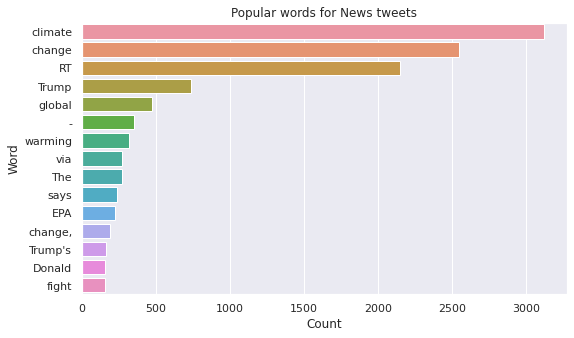

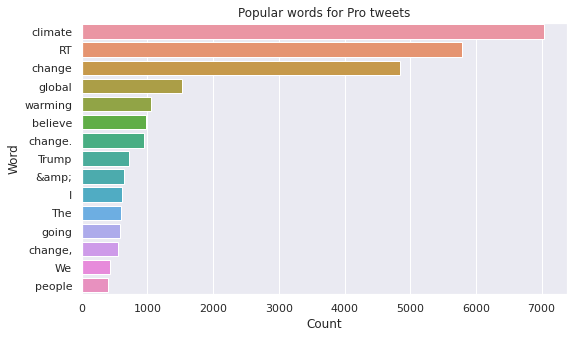

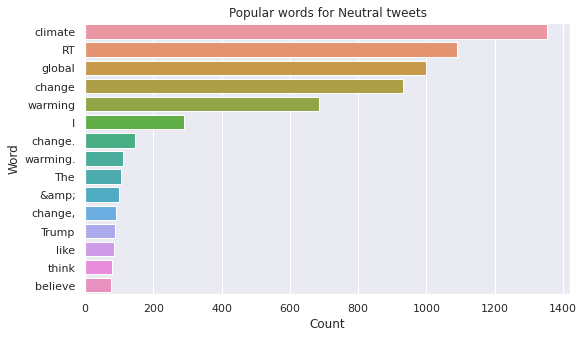

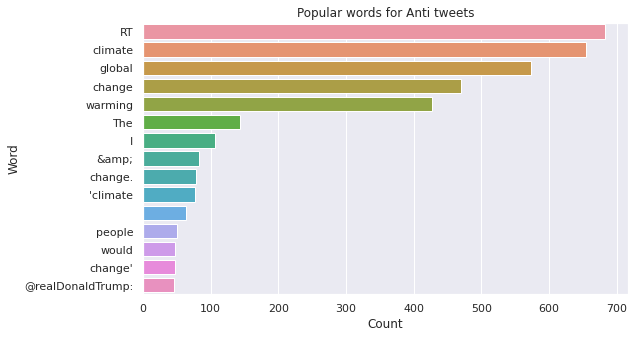

In [110]:
# Visualising sentiment class 
full_title = ['Popular words for News tweets',
              'Popular words for Pro tweets',
              'Popular words for Neutral tweets',
              'Popular words for Anti tweets']
#creating a list for the visuals 
tweet_list = [news_tweets, pro_tweets,
              neutral_tweets, anti_tweets]

plt.rcParams['figure.figsize'] = [40, 5]

for i, sent in enumerate(tweet_list):
    plt.subplot(1, 4, i + 1)
    freq_dist = nltk.FreqDist(sent.split(' '))
    df = pd.DataFrame({'Word': list(freq_dist.keys()),
                      'Count' : list(freq_dist.values())})

    df = df.nlargest(columns='Count', n=15)

    ax = sns.barplot(data=df, y='Word', x='Count')
    plt.title(full_title[i])
    plt.show()

- We see that there are some examples of words that are unique to a sentiment in the dataset e.g 'EPA'.
- We also see that some words are quite common everywere e.g. 'trump'

####  Wordcloud
We next create a wordcloud to properly visualize the occurence of words in in the dataset 

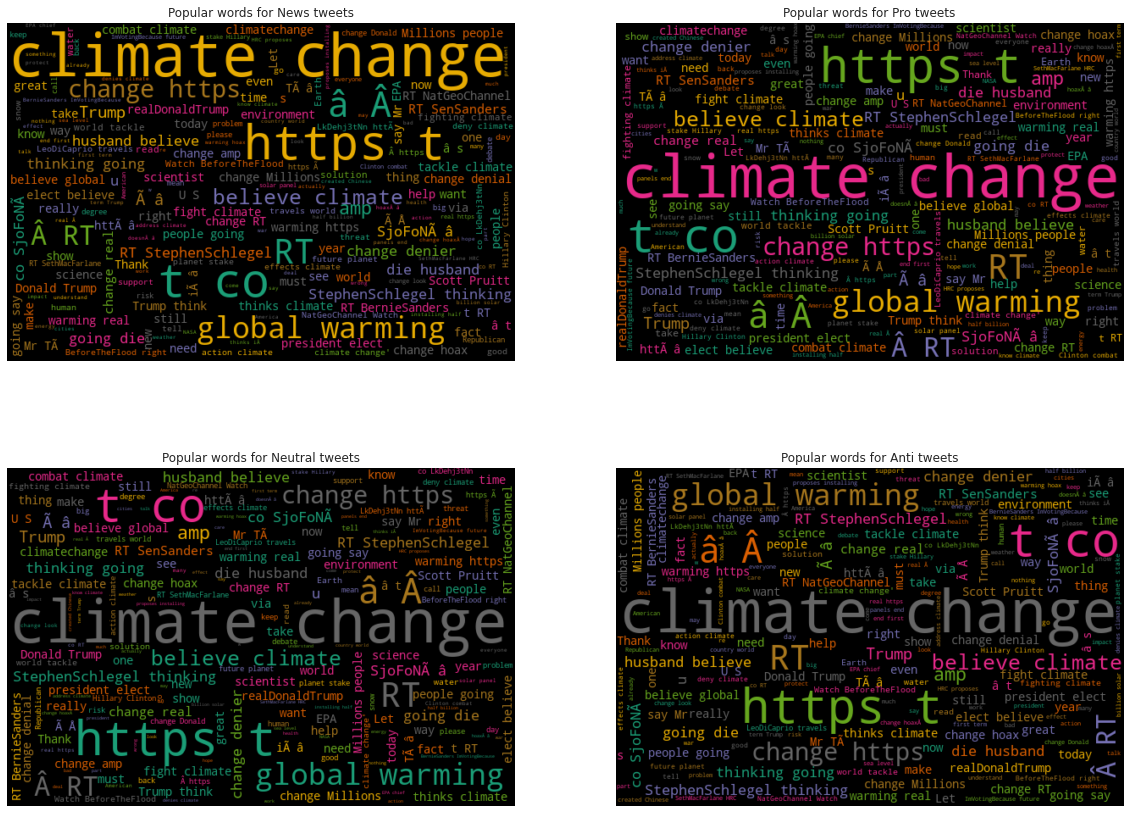

In [111]:
# Create word clouds of the most common words in each sentiment class
wc = WordCloud(width=600, height=400, 
               background_color='black', colormap='Dark2',
               max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots 
for i in range(0, len(tweet_list)):
    wc.generate(tweet_list[1])
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(full_title[i])
    
plt.show()

**Observation:**
* The size of the word in the wordcloud indicates the relevance in the tweet.
* The most popular words in all four classes are climate change, global warming and belief.
* The pro and anti groups include a number of words that might be expected in each group.
* In the word clouds there is evidence of noisy text which include words such as https, webside, co and RT. These do not assist us in our classification, rather they add noise, we will have another look at it when the noise have been removed.
* https occurs frequently in pro climate change tweets, implying that many links are being shared around the topic of climate change. These could be links to petitions, websites and/or articles related to climate change. Interesting to note: https only occurs in the top 25 words for the pro climate change class. Why aren't we seeing more links in the news class?

#### Mention Analysis

A mention is a Tweet that contains another person's username anywhere in the body of the Tweet. We collect these messages, as well as all the replies. Including multiple usernames in a Tweet, all of those people you mentioned will see your Tweet.

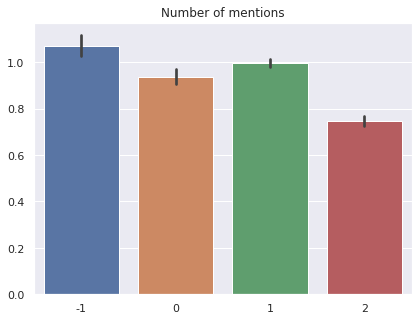

In [13]:
"""
We calculate the number of mentions we have for each sentiment in a tweet
"""

# mention count 
train1['mentions'] = train1['message'].apply(lambda x: len([i for i in str(x) if i == '@']))

#plot the number of mentions
plt.subplot(1,3,3)
sns.barplot(y='mentions', x='sentiment', data=train1)
plt.title('Number of mentions')
plt.ylabel('')
plt.xlabel('')
fig = plt.gcf()
fig.set_size_inches( 23, 5)

plt.show()

 **Observation:**

The pro and neutral setiments seem to have the most mentions in the tweets compared to the news and anti sentiment classes. 

#### Extracting hashtags

People use the hashtag symbol (#) before a relevant keyword or phrase in their Tweet to categorize those Tweets and help them show more easily in Twitter search. Clicking or tapping on a hashtagged word in any message shows you other Tweets that include that hashtag. Hashtags can be included anywhere in a Tweet

In [14]:
# Creating a function to extract hashtags from tweets

def extract_hashtags(x):
    hashtags = []
    for i in x:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
        
    return hashtags

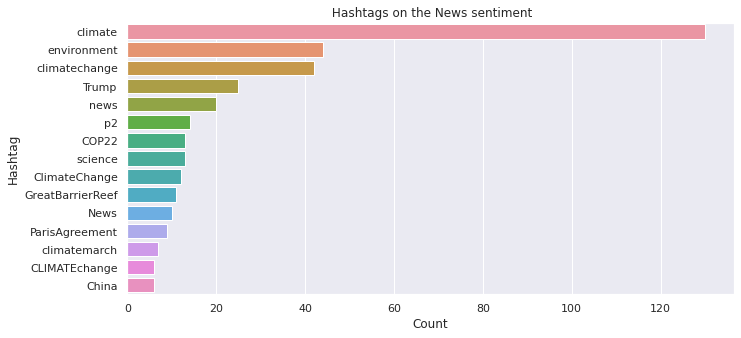

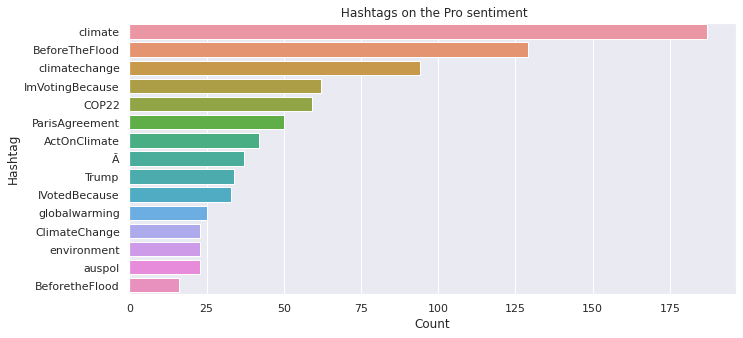

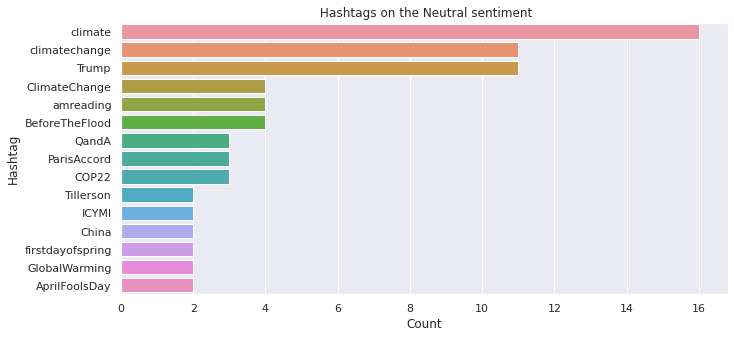

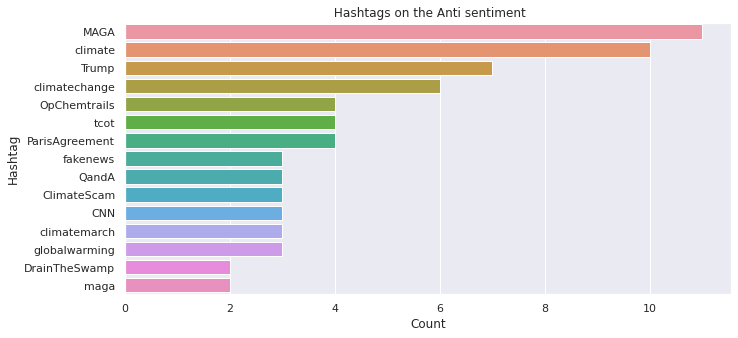

In [15]:
# Extracting hashtags from tweets
news_h = extract_hashtags(tweet_df['message']
                              [tweet_df['sentiment'] == 2])
pro_h = extract_hashtags(tweet_df['message']
                          [tweet_df['sentiment'] == 1])
neutral_h = extract_hashtags(tweet_df['message']
                              [tweet_df['sentiment'] == 0])
anti_h = extract_hashtags(tweet_df['message']
                          [tweet_df['sentiment'] == -1])

# hashtag list
hashtags = [sum(news_h, []), sum(pro_h, []),
            sum(neutral_h, []),sum(anti_h, [])]

# Visualising the Hashtags
ft = [' Hashtags on the News sentiment',
              ' Hashtags on the Pro sentiment',
              ' Hashtags on the Neutral sentiment',
              ' Hashtags on the Anti sentiment']

plt.rcParams['figure.figsize'] = [50, 5]

for i, sent in enumerate(hashtags):
    plt.subplot(1, 4, i + 1)
    freq_dist = nltk.FreqDist(sent)
    df = pd.DataFrame({'Hashtag': list(freq_dist.keys()),
                      'Count' : list(freq_dist.values())})

    df = df.nlargest(columns='Count', n=15)

    ax = sns.barplot(data=df, y='Hashtag', x='Count')
    plt.title(ft[i])
    plt.show()

**Observation:**

* We can see that the top 5 hashtags have similar words like Climate, climate change, Trump and Before the flood
* Before the flood is a popular hashtags used in pro climate change tweets, this refers to a 2016 documentary where actor Leonardo DiCaprio meets with scientists, activists and world leaders to discuss the dangers of climate change and possible solutions.
* In the anti climate change tweets MAGA (Make America great again) is the top popular hashtag. It is a slogan that was often used by Donald Trump during his campaign for elections in 2016. This soon became a trending hashtag to use to show support for Donald Trump., 

### Twitter Handles

A Twitter handle is the username that appears at the end of your unique Twitter URL. Twitter handles appear after the @ sign in your profile URL and it must be unique to your account. A Twitter name, on the other hand, is simply there to help people find the company they're looking for.

In [16]:
# Creating a function to extract handles from tweets
def extract_handles(x):
    handles = []
    for i in x:
        h = re.findall(r'@(\w+)', i)
        handles.append(h)
        
    return handles

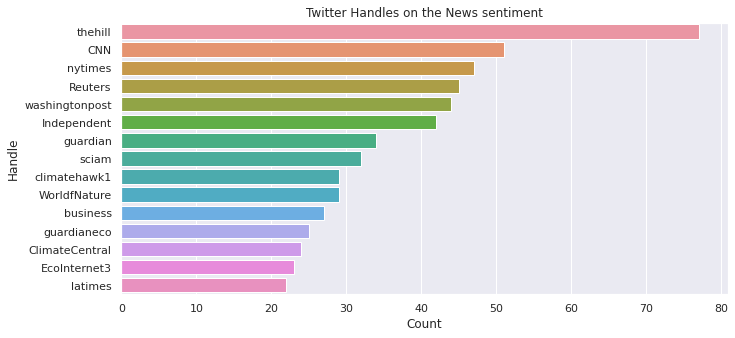

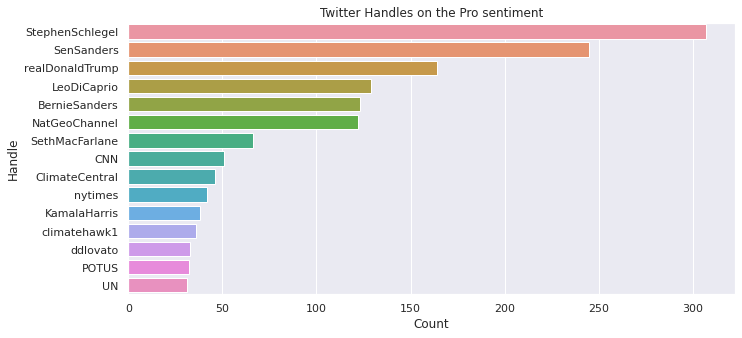

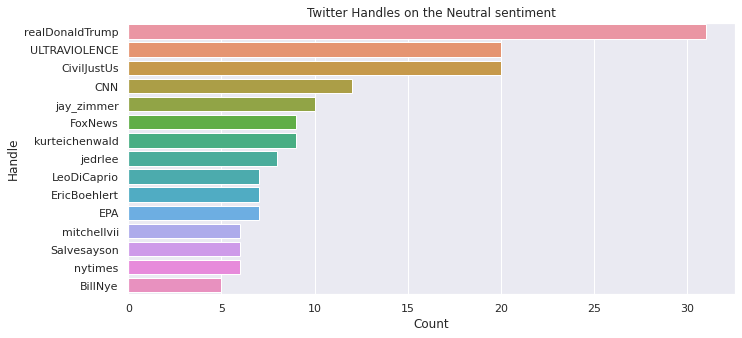

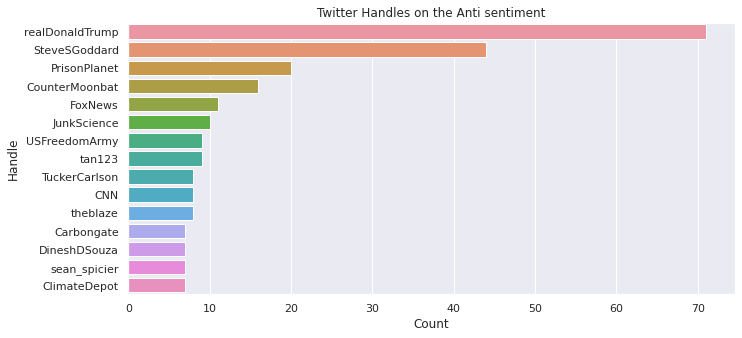

In [17]:
# Extracting handles from tweets
news_h = extract_handles(tweet_df['message']
                              [tweet_df['sentiment'] == 2])
pro_h = extract_handles(tweet_df['message']
                          [tweet_df['sentiment'] == 1])
neutral_h = extract_handles(tweet_df['message']
                              [tweet_df['sentiment'] == 0])
anti_h = extract_handles(tweet_df['message']
                          [tweet_df['sentiment'] == -1])

# handle lists 
handles = [sum(news_h, []), sum(pro_h, []), sum(neutral_h, []),
           sum(anti_h, [])]

# Visualising the Handles
full_title = ['Twitter Handles on the News sentiment',
              'Twitter Handles on the Pro sentiment',
              'Twitter Handles on the Neutral sentiment',
              'Twitter Handles on the Anti sentiment']

plt.rcParams['figure.figsize'] = [50, 5]

for i, sent in enumerate(handles):
    plt.subplot(1, 4, i + 1)
    freq_dist = nltk.FreqDist(sent)
    df = pd.DataFrame({'Handle': list(freq_dist.keys()),
                      'Count' : list(freq_dist.values())})

    df = df.nlargest(columns='Count', n=15)

    ax = sns.barplot(data=df, y='Handle', x='Count')
    plt.title(full_title[i])
    plt.show()

**Observations**

From the Visuals above we can all that ...
* The most popular News handles are actual news broadcaster accounts
* The most popular Pro handles seem to be celebrity accounts & news accounts.
* Trump features most for most popular Anti & Neutral tweets.

####  We next look at the number of web links tweets in the different sentiments contain 

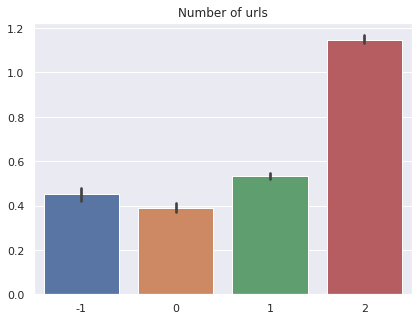

In [18]:
# extracting urls
train1['urls'] = train1['message'].apply(lambda x: len([i for i in x.lower().split() if 'http' in i or 'https' in i]))

# ploting the number of urls
plt.subplot(1,3,3)
sns.barplot(y='urls', x='sentiment', data=train1)
plt.title('Number of urls')
plt.ylabel('')
plt.xlabel('')
fig = plt.gcf()
fig.set_size_inches( 23, 5)

plt.show()

**Observation:** There is not much difference between the number of urls in each setiment. 

### Retweets

Twitter allows a user to retweet, or RT another users tweets. We see RT as a popular word in the above visuals. This is great for creating trends, but not useful for sentiment analysis. Now we will remove the duplicates to get a clearer picture of our data set.

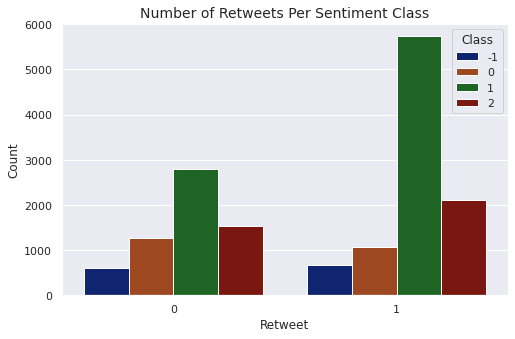

In [19]:
# Class distribution for set of retweeted-tweets and set without retweets
plt.figure(figsize = (8,5))
train1['retweet'] = train1['message'].apply(lambda tweet: 1 if tweet.startswith('RT @') else 0)
sns.countplot(x='retweet', data=train1, palette='dark', hue='sentiment')
plt.title('Number of Retweets Per Sentiment Class',fontsize=14)
plt.xlabel('Retweet')
plt.ylabel('Count')
plt.legend(title='Class')
plt.show()

**Observations:**

The Pro sentiment class seems to have more tweets retweeted with over 5000 retweets. while other sentiment classes have less than 2000 retweets. looks like evryone is retweeting positive climate change tweets more than others.

### EDA summary

Whew that was a lengthy eda, let us summarize our findings

- Our data is unmbalanced
- The occurence of certain words, hashtags, and twitter handles in a tweet can serve as good indicators for a particular sentiment
- The amount of retweets too can serve as good indicators

Armed with this information about the data, we can now proceed to do some feature engineering

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Data engineering ⚡ |
| :--------------------------- |
| In this section you are required to: clean the dataset, and possibly create new features - as identified in the EDA phase. |

---

In [20]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

#### We start by balancing the data

In [21]:
all_msg = df.copy()

We will upsample the observations from the under-represented classes and down sample the observation from the pro climate class as it is the one with the most observations

In [22]:
#seperate the sentiments
df_pro= all_msg[all_msg['sentiment']==1]
df_news= all_msg[all_msg['sentiment']==2]
df_neutral= all_msg[all_msg['sentiment']==0]
df_anti= all_msg[all_msg['sentiment']== -1]

#upsample minority class seperately
df_anti_upsampled= resample(df_anti,
                            replace=True,
                            n_samples=4265,
                            random_state=42
                            )
df_neutral_upsampled= resample(df_neutral,
                            replace=True,
                            n_samples=4265,
                            random_state=42
                            )
df_factual_upsampled= resample(df_news,
                            replace=True,
                            n_samples=4265,
                            random_state=42
                            )

#downsample majority class
df_pro_downsampled = resample(df_pro,
                              replace=False,
                              n_samples= 4265,
                              random_state=42
                             )

#Number of observations for each sentiment class
print("Anti", df_anti.shape)
print("Neutral", df_neutral.shape)
print("Pro", df_pro.shape)
print("Factual", df_news.shape, "\n")

#combine the dataframes
all_msg_2= pd.concat([df_pro_downsampled, df_factual_upsampled, df_neutral_upsampled, df_anti_upsampled])
print ("Balanced Data \n", all_msg_2['sentiment'].value_counts())

Anti (1296, 3)
Neutral (2353, 3)
Pro (8530, 3)
Factual (3640, 3) 

Balanced Data 
  1    4265
 2    4265
 0    4265
-1    4265
Name: sentiment, dtype: int64


We will preceed to train our models with both the balanced and unbalanced data and later acertain which approach produces a better performance

#### Next we extract the top handles/hashtags that are present in the dataset on a per sentiment basis

In [23]:
'''This function takes a dataframe, and number e.g. 10 and a search parameter e.g. @ and returns
in the above mentioned case, the top 10 words that starts with the char @ (this would be twitter handles)
We can alter the search to return hashtags by supplying #'''

def get_top_n_tweets(df, n, search):
    twitter_handles = {}
    for message in df['message']:
        for word in message.split(" "):
            if len(word) > 0 and word[0] == search:
                try:
                    twitter_handles[word] = twitter_handles[word] + 1
                except:
                    twitter_handles[word] = 1

    handle_array = []
    for key in twitter_handles:
        handle_array.append((key, twitter_handles[key]))

    handle_array.sort(reverse=True, key=lambda item: item[1])
    top_tweet_handles = handle_array[:n]
    
    return list(map(lambda item: item[0], top_tweet_handles))

In [24]:
def top_n_tweets(n, search='@', balanced=False):
    df_list = [df_pro, df_news, df_neutral, df_anti]
    result = []
    for df in df_list:
        result = result + get_top_n_tweets(df, n, search)
    return result 

def top_n_tweets_balanced(n, search='@'):
    f
    

special_handles = top_n_tweets(10)
special_hashtags = top_n_tweets(10, '#')

special_words = np.array(special_handles + special_hashtags)

In [25]:
special_words

array(['@StephenSchlegel:', '@SenSanders:', '@realDonaldTrump',
       '@BernieSanders:', '@LeoDiCaprio', '@NatGeoChannel:',
       '@SethMacFarlane:', '@ClimateCentral:', '@NatGeoChannel', '@CNN:',
       '@thehill:', '@CNN:', '@nytimes:', '@Independent:',
       '@washingtonpost:', '@guardian:', '@climatehawk1:', '@sciam:',
       '@WorldfNature:', '@guardianeco:', '@realDonaldTrump',
       '@ULTRAVlOLENCE:', '@CivilJustUs:', '@CNN', '@jay_zimmer:',
       '@FoxNews', '@jedrlee:', '@EricBoehlert:', '@kurteichenwald:',
       '@EPA', '@realDonaldTrump:', '@SteveSGoddard:', '@realDonaldTrump',
       '@CounterMoonbat:', '@PrisonPlanet:', '@USFreedomArmy:', '@CNN',
       '@JunkScience:', '@FoxNews', '@tan123:', '#climate',
       '#BeforeTheFlood', '#climatechange', '#ImVotingBecause', '#COP22',
       '#ParisAgreement', '#Ã¢â‚¬Â¦', '#IVotedBecause', '#ActOnClimate',
       '#Trump', '#climate', '#environment', '#climatechange', '#news',
       '#Trump', '#p2', '#science', '#GreatBarr

#### We will now use these special words to generate more features

In [26]:
# This checks for the occurence of a particular word and returns the count 
# This is helpful as it helps produce the count of the special words we extracted from the word cloud

def count_word_occurrence(word):
    def count(text):
        word_list = text.split(" ")
        word_count = 0
        for item in word_list:
            if item == word:
                word_count = word_count + 1
        return word_count
    return count

# function takes a dataframe and a list of words returns the dataframe with those list of words as new columns
# and the count of those words as the data in the columns

def add_features_from_list(df, feature_list):
    for feature in feature_list:
        df[feature] = df['message'].apply(count_word_occurrence(feature))

In [112]:
add_features_from_list(all_msg, special_words)
add_features_from_list(all_msg_2, special_words)

# we add features to both the balanced and unbalanced data
all_msg = all_msg.copy()
all_msg_2 = all_msg_2.copy()
all_msg.head()

,sentiment,message,tweetid,@StephenSchlegel:,@SenSanders:,@realDonaldTrump,@BernieSanders:,@LeoDiCaprio,@NatGeoChannel:,@SethMacFarlane:,...,#AprilFoolsDay,#ParisAccord,#MAGA,#OpChemtrails,#QandA,#ClimateScam,#CNN,#fakenews,tokens,lemma
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,its not like we lack evidence of anthropogenic...,126103,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[its, not, like, we, lack, evidence, of, anthr...","[it, not, like, we, lack, evidence, of, anthro..."
2,2,rt rawstory researchers say we have three year...,698562,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[rt, rawstory, researchers, say, we, have, thr...","[rt, rawstory, researcher, say, we, have, thre..."
3,1,todayinmaker wired 2016 was a pivotal year in...,573736,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[todayinmaker, wired, 2016, was, a, pivotal, y...","[todayinmaker, wired, 2016, wa, a, pivotal, ye..."
4,1,rt soynoviodetodas its 2016 and a racist sexis...,466954,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[rt, soynoviodetodas, its, 2016, and, a, racis...","[rt, soynoviodetodas, it, 2016, and, a, racist..."


We next clean the data some more by creating a function to replace all url with a common text : "url-web"

In [28]:
#removing web URL
def replace_urls(df, column):
    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    subs_url = r'url-web'
    df[column] = df[column].replace(to_replace = pattern_url, value = subs_url, regex = True)
    return 
all_msg_2
replace_urls(all_msg, 'message') # unbalanced data
replace_urls(all_msg_2, 'message') # balanced data

We next convert the message text to lowercase to increase the uniformity of the text 

In [29]:
#converting message column to lower case
def to_lowercase(df, column):
    df['message'] = df['message'].str.lower()
    return

to_lowercase(all_msg, 'message')
to_lowercase(all_msg_2, 'message')

We next removed punctuations

In [30]:
#remove punctuation
def remove_punctuation(post):
    return ''.join([l for l in post if l not in string.punctuation])

all_msg['message'] = all_msg['message'].apply(remove_punctuation)
all_msg_2['message'] = all_msg_2['message'].apply(remove_punctuation)

In [31]:
# Next we create tokens out the words

tokeniser = TreebankWordTokenizer()
all_msg['tokens'] = all_msg['message'].apply(tokeniser.tokenize)
all_msg_2['tokens'] = all_msg_2['message'].apply(tokeniser.tokenize)

In [32]:
# we next converts the tokens to their root lemma 

lemmatizer = WordNetLemmatizer()
def mbti_lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]    

all_msg['lemma'] = all_msg['tokens'].apply(mbti_lemma, args=(lemmatizer, ))
all_msg_2['lemma'] = all_msg_2['tokens'].apply(mbti_lemma, args=(lemmatizer, ))

We next add some additional tweet metadata to the dataframe, they include;

- average_word_length, 
- number of citations in the tweets
- number of retweets
- number of words

All these extra data can help us estimate the level of education (i.e. in the case of word length, word count etc), and as previously mentioned retweets can be a good indicator of sentiments

In [33]:
added_info = all_msg.copy()

# This helps to count the number of words in a particular tweet
def count_words(word):
    word_list = word.split(" ")
    return len(word_list)

added_info['word_count'] = added_info['message'].apply(count_words)
all_msg_2['word_count'] = all_msg_2['message'].apply(count_words)

# This helps to calculate the average word length used. Might be a good indicator of education status
def avg_word_length(word):
    string_length =  len(word)
    word_list = word.split(" ")
    word_count = len(word_list)
    return string_length/word_count

added_info['avg_word_length'] = added_info['message'].apply(avg_word_length)
all_msg_2['avg_word_length'] = all_msg_2['message'].apply(avg_word_length)

# Citations basically counts how many web links are in the tweets e.g. the word cloud indicated that news articles 
# almost are very rich in web links
def count_citations(word):
    word_list = word.split(" ")
    count = 0 
    
    for word in word_list:
        if word == "urlweb":
            count = count + 1
            
    return count            

added_info['citations'] = added_info['message'].apply(count_citations)
all_msg_2['citations'] = all_msg_2['message'].apply(count_citations)

# We next count the number of retweets in the data
def count_retweets(word):
    word_list = word.split(" ")
    rt_count = 0
    for word in word_list:
        if word == 'rt':
            rt_count = rt_count + 1
    return rt_count

added_info['rt_count'] = added_info['message'].apply(count_retweets)
all_msg_2['rt_count'] = all_msg_2['message'].apply(count_retweets)

def list_to_string(post):
    return ' '.join(post)

added_info['lemma'] = added_info['lemma'].apply(list_to_string)
all_msg_2['lemma'] = all_msg_2['lemma'].apply(list_to_string)


Our approach here is to train the models in two stages.
- The first stage trains some models using only the data from vectorizing the tweets 
- We next take our best performing models and use their predictions to create a new training data
- We will supplement the training data with the features we have been creating since e.g. features from the special words, as well as the additional tweet metadata we created.

### First stage - Train with the vectorized text

In [34]:
# We used a TFIDF vectorizer on the tweets - note we used a countVectorizer at first and noticed a TFIDF
# vectorizer worked best

tf_vect = TfidfVectorizer()
X_train_vect = tf_vect.fit_transform(added_info.lemma)
X_balanced = tf_vect.transform(all_msg_2.lemma)

# We extract the labels
y_balanced = all_msg_2.sentiment
y_train_df = added_info.sentiment

In [35]:
# we next split the data into a training an validation set for both balanced and unbalanced data

X_train, X_val, y_train, y_val = train_test_split(X_train_vect, y_train_df, test_size=0.20)

X_b_train, X_b_val, y_b_train, y_b_val = train_test_split(X_balanced, y_balanced, test_size=0.20)

let us save the additional features we have been creating for use later in a dataframe 

In [36]:
addition = added_info[added_info.drop(['tokens', 'lemma'], axis=1).columns[3:]]

In [37]:
addition_b = all_msg_2.drop(['sentiment', 'message', 'tweetid', 'tokens', 'lemma'], axis=1)
addition_b = addition_b.reset_index()

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Modelling ⚡ |
| :--------------------------- |
| In this section, you are required to create one or more classification models that is/are able to classify whether or not a person believes in climate change, based on their novel tweet data.

---

#### We build several models and tests their accuracy on both the balanced and unbalanced

Logistic regression

In [38]:
log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
log_clf.score(X_val, y_val)

/home/ikechukwu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.734197218710493

Logistic regression model trained on balanced data

In [39]:
log_clf_b = LogisticRegression()
log_clf_b.fit(X_b_train, y_b_train)
log_clf_b.score(X_b_val, y_b_val)

/home/ikechukwu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8323563892145369

Support Vector Machine

In [40]:
svc_lm = SVC(kernel="linear", C=1.2, probability=True)
svc_lm.fit(X_train, y_train)
svc_lm.score(X_val, y_val)

0.7601137800252844

Svm on balanced data

In [41]:
svc_lm_b = SVC(kernel="linear", C=1.2, probability=True)
svc_lm_b.fit(X_b_train, y_b_train)
svc_lm_b.score(X_b_val, y_b_val)

0.8660609613130129

Adaboost classifier

In [42]:
AdBoost = AdaBoostClassifier()
AdBoost.fit(X_train, y_train)
AdBoost.score(X_val, y_val)

0.6406447534766119

Adaboost on balanced data

In [43]:
AdBoost_b = AdaBoostClassifier()
AdBoost_b.fit(X_b_train, y_b_train)
AdBoost_b.score(X_b_val, y_b_val)

0.5565650644783119

Random forest model

In [44]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
RF.score(X_val, y_val)

0.7108091024020228

Random forest on balanced data

In [45]:
RF_b = RandomForestClassifier()
RF_b.fit(X_b_train, y_b_train)
RF_b.score(X_b_val, y_b_val)

0.8839390386869871

Multinomial Naive beyes model

In [46]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
MNB.score(X_val, y_val)

0.6346396965865992

Multinomial Naive beyes model on balanced data

In [47]:
MNB_b = MultinomialNB()
MNB_b.fit(X_b_train, y_b_train)
MNB_b.score(X_b_val, y_b_val)

0.8185814771395076

The model trained with balanced data peformed better than the ones trained on unbalanced data

We can see that our four highest perferming models in terms of accuracy are;
- logistic regression
- support vector machine
- Random forest model
- Naive beyes

We will sum the individual prediction of the different models for the different models to create a new training data 

We will attempt to improve the performance of models built with both the balanced and unbalanced data

In [48]:
# we evaluete the probability of predicting each class using our models
models_b = [log_clf_b, svc_lm_b, RF_b, MNB_b]
models = [log_clf, svc_lm, RF, MNB]
result_b = []
result = []

for model in models_b:
    result_b.append(model.predict_proba(X_train_vect))

for model in models:
    result.append(model.predict_proba(X_train_vect))

In [113]:
# we sum the probality of the predictions for both the balanced and unbalanced data
total_predict = sum(result)
total_predict_b = sum(result_b)

Let us now create a dataframe predictions

In [50]:
classes = ['classA', 'classB', 'classC', 'classD']
predict_df = pd.DataFrame(total_predict)
predict_df.columns = classes

predict_df_b = pd.DataFrame(total_predict_b)
predict_df_b.columns = classes

We will now create an interim dataset that comprises of the predictions of our initial models and the additional metadata will now add

In [114]:
interim = pd.concat([predict_df, addition], axis=1)
interim_b = pd.concat([predict_df_b, addition], axis=1)
interim.head(2)

,classA,classB,classC,classD,@StephenSchlegel:,@SenSanders:,@realDonaldTrump,@BernieSanders:,@LeoDiCaprio,@NatGeoChannel:,...,#MAGA,#OpChemtrails,#QandA,#ClimateScam,#CNN,#fakenews,word_count,avg_word_length,citations,rt_count
0,0.107053,0.234759,3.236844,0.421345,0,0,0,0,0,0,...,0,0,0,0,0,0,19,6.105263,1,0
1,0.392813,0.493894,3.071658,0.041635,0,0,0,0,0,0,...,0,0,0,0,0,0,10,6.100000,0,0


We will remove the '@' and '#' from the column names as shown above to prevent some warnings from our sklearn models during training

In [52]:
def remove_special_char(df):
    newcols = []
    for col in df.columns:
        if col[0] in ['@', '#']:
            newcols.append(col[1:])
        else:
            newcols.append(col)
    df.columns = newcols

remove_special_char(interim)
remove_special_char(interim_b)

In [53]:
m_Y = all_msg.sentiment

In [54]:
# We next split the data into training and validation again

m_train, m_val, m_y_train, m_y_val = train_test_split(interim, m_Y, test_size=0.20)
m_train_b, m_val_b, m_y_train_b, m_y_val_b = train_test_split(interim_b, m_Y, test_size=0.20)

#### We next train a second set of models to work with the interim data we have created so far

Logistic regression model

In [55]:
i_log_clf = LogisticRegression(C=20)
i_log_clf.fit(m_train, m_y_train)
i_log_clf.score(m_val, m_y_val)

/home/ikechukwu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.933944374209861

Logistic regresssion on balanced data

In [56]:
i_log_clf_b = LogisticRegression(C=20)
i_log_clf_b.fit(m_train_b, m_y_train_b)
i_log_clf_b.score(m_val_b, m_y_val_b)

/home/ikechukwu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8975979772439949

Support vector machine

In [57]:
i_svc_lm = SVC(kernel="linear")
i_svc_lm.fit(m_train, m_y_train)
i_svc_lm.score(m_val, m_y_val)

0.9345764854614412

Support Vector machine on balanced data

In [66]:
i_svc_lm_b = SVC(kernel="linear")
i_svc_lm_b.fit(m_train_b, m_y_train_b)
i_svc_lm_b.score(m_val_b, m_y_val_b)

0.8979140328697851

Random forests model

In [59]:
i_RF = RandomForestClassifier()
i_RF.fit(m_train, m_y_train)
i_RF.score(m_val, m_y_val)

0.9377370417193426

Random forests model on balanced data

In [60]:
i_RF_b = RandomForestClassifier()
i_RF_b.fit(m_train_b, m_y_train_b)
i_RF_b.score(m_val_b, m_y_val_b)

0.8985461441213654

Naive beyes model

In [61]:
i_MNB = MultinomialNB()
i_MNB.fit(m_train, m_y_train)
i_MNB.score(m_val, m_y_val)

0.9086599241466498

Naive beyes model on balanced data

In [62]:
i_MNB_b = MultinomialNB()
i_MNB_b.fit(m_train, m_y_train)
i_MNB_b.score(m_val, m_y_val)

0.9086599241466498

We can immediately see that the performance of the models increased after the second stage of training

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model performance ⚡ |
| :--------------------------- |
| In this section you are required to compare the relative performance of the various trained ML models on a holdout dataset and comment on what model is the best and why. |

---

In [83]:
models_names = ['1_log_reg', 
                '1_log_reg balanced', 
                '1_svm', 
                '1_svm balanced',
                '1_Ada',
                '1_Ada balanced',
                '1_RF',
                '1_RF balanced',
                '1_NB beyes',
                '1_NB balanced'
               ]
models = [log_clf, log_clf_b, svc_lm, svc_lm_b, AdBoost, AdBoost_b, RF, RF_b, MNB, MNB_b]
f1_scores = []

for model in models:
    f1_scores.append(round(f1_score(y_val, model.predict(X_val), average='micro'), 2)*100)

<AxesSubplot:xlabel='model names', ylabel='f1 score'>

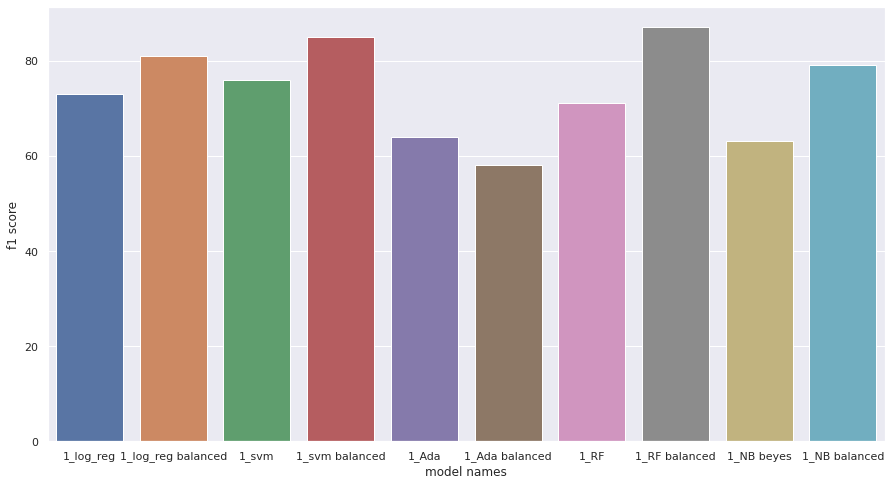

In [84]:
peformance = pd.DataFrame({'model names': models_names, 'f1 score': f1_scores})

rcParams['figure.figsize'] = 15,8
sns.barplot(y='f1 score', x='model names', data=peformance)

#### We can see that the in the first stage, the models trained on balanced data consistently out performed the data trained on an unbalanced model

In [80]:
models_names = ['2_log_reg', 
                '2_log_reg balanced', 
                '2_svm', 
                '2_svm balanced',
                '2_RF',
                '2_RF balanced',
                '2_NB beyes',
                '2_NB balanced'
               ]
models = [i_log_clf, i_log_clf_b, i_svc_lm, i_svc_lm_b,  i_RF, i_RF_b,  i_MNB, i_MNB_b]
f1_scores = []

for model in models:
    f1_scores.append(round(f1_score(m_y_val, model.predict(m_val), average='micro'), 2)*100)

<AxesSubplot:xlabel='model names', ylabel='f1 score'>

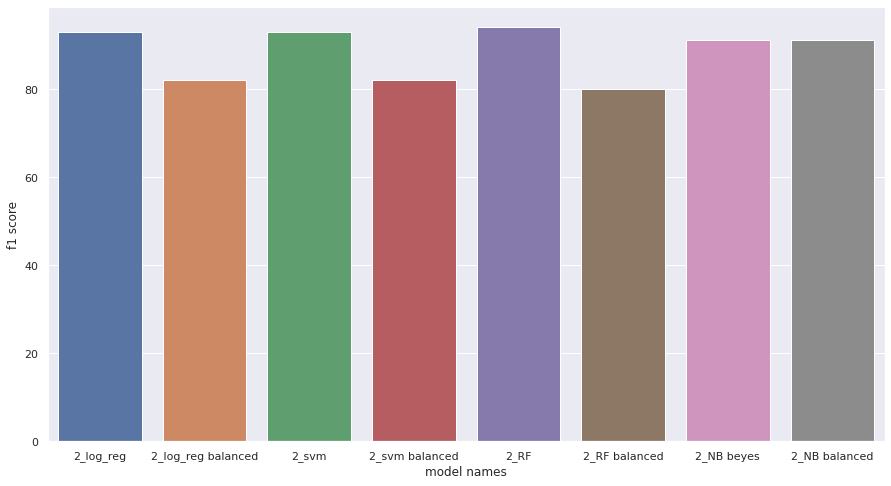

In [81]:
peformance = pd.DataFrame({'model names': models_names, 'f1 score': f1_scores})

rcParams['figure.figsize'] = 15,8
sns.barplot(y='f1 score', x='model names', data=peformance)

#### After the second stage of training the models trained on unbalanced data showed significant improvements over their balanced counterparts

Ultimately, The logistic regression model trained on unbalanced data proved to be the most accurate on the unseen kaggle data

### Prepare for submission

In [85]:
test = df_test.copy()
# We will preprocess the data using all the steps already discussed
add_features_from_list(test, special_words)
replace_urls(test, 'message')
to_lowercase(test, 'message')
test['message'] = test['message'].apply(remove_punctuation)
test['tokens'] = test['message'].apply(tokeniser.tokenize)
test['lemma'] = test['tokens'].apply(mbti_lemma, args=(lemmatizer, ))
test['lemma'] = test['lemma'].apply(list_to_string)
X_test2 = tf_vect.transform(test['lemma'])

In [86]:
test['word_count'] = test['message'].apply(count_words)
test['avg_word_length'] = test['message'].apply(avg_word_length)     
test['citations'] = test['message'].apply(count_citations)
test['rt_count'] = test['message'].apply(count_retweets)
test_addition = test.drop(['message', 'tweetid', 'tokens', 'lemma'], axis=1)
remove_special_char(test_addition)
test_addition.head(1)

,StephenSchlegel:,SenSanders:,realDonaldTrump,BernieSanders:,LeoDiCaprio,NatGeoChannel:,SethMacFarlane:,ClimateCentral:,NatGeoChannel,CNN:,...,MAGA,OpChemtrails,QandA,ClimateScam,CNN,fakenews,word_count,avg_word_length,citations,rt_count
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,20,5.2,1,0


In [87]:
# we next evaluate the probality of an observation being in each class using our first stage models
models = [log_clf, svc_lm, RF, MNB]
result = []

for model in models:
    result.append(model.predict_proba(X_test2))

test_predict = sum(result)

In [88]:
# We sum up the probabilities and create an intermediate dataset as before
classes = ['classA', 'classB', 'classC', 'classD']
test_predict_df = pd.DataFrame(test_predict)
test_predict_df.columns = classes

interim_test = pd.concat([test_predict_df, test_addition], axis=1)
interim_test.head()

,classA,classB,classC,classD,StephenSchlegel:,SenSanders:,realDonaldTrump,BernieSanders:,LeoDiCaprio,NatGeoChannel:,...,MAGA,OpChemtrails,QandA,ClimateScam,CNN,fakenews,word_count,avg_word_length,citations,rt_count
0,0.102742,0.156513,3.325644,0.415101,0,0,0,0,0,0,...,0,0,0,0,0,0,20,5.200000,1,0
1,0.102268,0.566481,3.116773,0.214477,0,0,0,0,0,0,...,0,0,0,0,0,0,20,5.650000,1,0
2,0.063080,0.212328,3.540905,0.183687,0,0,0,0,0,0,...,0,0,0,0,0,0,14,8.071429,1,0
3,0.165418,0.479180,3.257397,0.098005,0,0,0,0,0,0,...,0,0,0,0,0,0,23,5.608696,0,0
4,0.270539,1.943593,1.433534,0.352335,0,0,0,0,0,0,...,0,0,0,0,0,0,8,9.125000,0,1


In [90]:
# finally we make predictions using our second stage models and intermediate dataset
predictions = i_log_clf.predict(interim_test)


df_CSV = pd.DataFrame({"tweetid": df_test['tweetid'].values,
                   "sentiment": predictions,
                  })

df_CSV.to_csv("Team6_sample_MNB_ProT.csv", index=False)

### Save the model

In [91]:
# We will now create pickled versions of our models for use in deployment

models = [{'model': tf_vect, 'path': 'tf_vect.pkl'},
          {'model': log_clf, 'path': 'logreg2.pkl'},
          {'model': svc_lm, 'path': 'svc_lm2.pkl'},
          {'model': RF, 'path': 'RF2.pkl'},
          {'model': MNB, 'path': 'MNB.pkl'},
          {'model': i_log_clf, 'path': 'm_log_clf.pkl'},
          {'model': i_svc_lm, 'path': 'm_svc_lm2.pkl'},
          {'model': i_RF, 'path': 'm_RF2.pkl'},
          {'model': i_MNB, 'path': 'i_MNB2.pkl'},
         ]

def save_model(model, path):
    with open(path, 'wb') as file:
        pickle.dump(model, file)
    return

for item in models:
    save_model(item['model'], item['path'])

Save the special words as well as it is a part of the feature extraction

In [92]:
pd.DataFrame({'special_words': special_words}).to_csv("special_words.csv")

Set up comet to save model details

In [93]:
# Setting the API key (saved as environment variable)

# Create an experiment with your api key
experiment = Experiment(
    api_key="CiIdM6vK7NzhmF0W3SwXaz3RE",
    project_name="edsa",
    workspace="sholaog",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/home/ikechukwu/Desktop/Explore Data Science/Advanced classification Sprint Files/temp' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sholaog/edsa/71c78f0329244e0e9fb3b1a9f9a47cbd



In [115]:
y_predicted = i_log_clf.predict(m_val)

experiment.log_confusion_matrix(m_y_val, y_predicted)
F1 = f1_score(m_y_val, y_predicted, average='micro')
Pre = precision_score(m_y_val, y_predicted, average='micro')
Re = recall_score(m_y_val, y_predicted, average='micro')
CR = classification_report(m_y_val, y_predicted)

COMET ERROR: Error creating confusion matrix: 0; ignoring


In [116]:
params = {"model_type": "Logistic Regrestion",
          "Vectorizer": "CountVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2)",
          "test_size": 0.2
          }
metrics = {"F1 Score": F1,
           "Recall": Re,
           "Rrecision": Pre,
           "Classification Report": CR
           }

In [117]:
# Log our parameters and results
experiment.log_parameters(params)
experiment.log_metrics(metrics)

In [74]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/sholaog/edsa/453914591e664cf4b4d2debb0ebd4ce9
COMET INFO:   Metrics:
COMET INFO:     Classification Report :               precision    recall  f1-score   support

          -1       0.95      0.94      0.94       283
           0       0.89      0.81      0.85       485
           1       0.90      0.93      0.91      1677
           2       0.89      0.88      0.88       719

    accuracy                           0.90      3164
   macro avg       0.91      0.89      0.90      3164
weighted avg       0.90      0.90      0.90      3164

COMET INFO:     F1 Score              : 0.8994943109987358
COMET INFO:     Recall                : 0.8994943109987358
COMET INFO:     Rrecision             : 0.8994943109987358
COMET INFO:   Parameters:
COMET INFO